In [85]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from tqdm import tqdm

In [86]:
health_spend_dir = Path("../data/raw/IHME_HEALTH_SPENDING_2000_2017_ESTIMATES_CSV")
children = list(health_spend_dir.iterdir())

In [87]:
data_list = []
for fp in tqdm(children):
    all_ests = pd.read_csv(fp)
    latest_ests = all_ests[all_ests['year'] == 2017] # 2017 is latest estimate year.
    total_spend_ests = latest_ests[latest_ests['variable'] == 'Health expenditures in 2017 USD (millions)'] # Only care about total spend
    total_spend_ests = total_spend_ests[total_spend_ests['hp'] == 'Total'] # Only use aggregate provide spend estimates
    data_list.append(total_spend_ests)

ests = pd.concat(data_list)

100%|██████████| 195/195 [00:13<00:00, 14.51it/s]


In [88]:
# Drop all subcategories for curative care, rehabilitative care, long-term care, and medical goods
ds = ests[~ests['hc'].str.contains(r'^1\.|^2\.|^3\.|^5\.', regex=True)]
remaining_hcs = ds['hc'].unique()
filtered_hcs = ests.loc[~ests['hc'].isin(remaining_hcs), 'hc'].unique()
filtered_hcs

array(['1.1', '1.2', '1.3', '1.3.1', '1.3.2', '1.3.3', '1.3.nec', '1.4',
       '1.nec', '2.1', '2.2', '2.3', '2.4', '2.nec', '3.1', '3.2', '3.3',
       '3.4', '3.nec', '5.1', '5.1.1', '5.1.2', '5.1.3', '5.2', '5.nec'],
      dtype=object)

Correct filtering. Ancillary services.

In [89]:
# Filter for preventative care (HC.6), but exclude immunisation (6.2), early disease detection (6.3), surveillance/risk (6.5), and disaster prep (6.6)
other_prev_care_codes = ['6.1', '6.4', '6.nec']
other_prev_care = ds[ds['hc'].isin(other_prev_care_codes)]

# Group by country and variable, sum the values for "other preventative care"
other_prev_care_sum = (
    other_prev_care
    .groupby(['location_name', 'iso3'], as_index=False)[['lower', 'value', 'upper']]
    .sum()
    .assign(hc='6.99')
)
other_prev_care_sum['hc_name'] = '6. Other preventative care'


# Append these new rows to the original dataframe
ds = pd.concat([ds, other_prev_care_sum], ignore_index=True)
ds_next = ds[~ds['hc'].isin(other_prev_care_codes)]
ds_next = ds_next.sort_values(['location_name', 'hc'])

In [90]:
wb_classes = pd.read_excel("../data/raw/CLASS_2025_07_02.xlsx")

In [91]:
wb_classes = wb_classes.rename(columns=lambda s: s.lower().replace(' ', '_'))
wb_classes = wb_classes.rename(columns={'code': 'iso3'})
ds_final = ds_next.merge(wb_classes[['iso3', 'income_group']], on='iso3')

In [92]:
ds_final['hc_name'].value_counts()

hc_name
1. Curative care                                                                195
2. Rehabilitative care                                                          195
3. Long-term care                                                               195
4. Ancillary care                                                               195
5. Medical goods                                                                195
6. Preventative care                                                            195
6.2 Prevention care - Immunization programs                                     195
6.3 Prevention care - Early disease detection                                   195
6.5 Prevention care - Epi surveillance and risk and disease control programs    195
6.6 Prevention care - Preparing for disaster and emergency response programs    195
6. Other preventative care                                                      195
7. Governance & admin                                               

In [147]:
ds_income_group = (
    ds_final
    .groupby(['hc', 'hc_name', 'income_group'])[['lower', 'value', 'upper']]
    .sum()
    .apply(lambda x: x / 1e3)  # Convert to billions
)
ds_income_group = ds_income_group.reset_index()
ds_income_group.head()

,hc,hc_name,income_group,lower,value,upper
0,1,1. Curative care,High income,1058.68655,3128.38798,3959.95596
1,1,1. Curative care,Low income,4.42982,9.70287,13.37145
2,1,1. Curative care,Lower middle income,91.29690,140.93080,176.64197
3,1,1. Curative care,Upper middle income,305.13646,668.95827,918.50735
4,2,2. Rehabilitative care,High income,44.55861,165.28903,690.08773


In [148]:
# Define a mapping from full hc_name to cleaned-up versions
hc_name_map = {
    '1. Curative care': 'Curative care',
    '2. Rehabilitative care': 'Rehabilitative care',
    '3. Long-term care': 'Long-term care',
    '4. Ancillary care': 'Ancillary care',
    '5. Medical goods': 'Medical goods',
    '6. Preventative care': 'Preventative care',
    '6.2 Prevention care - Immunization programs': 'Immunization',
    '6.3 Prevention care - Early disease detection': 'Early detection',
    '6.5 Prevention care - Epi surveillance and risk and disease control programs': 'Surveillance & disease control',
    '6.6 Prevention care - Preparing for disaster and emergency response programs': 'Disaster preparedness',
    '6. Other preventative care': 'Other preventive care',
    '7. Governance & admin': 'Governance & admin',
    '9. Other health care services': 'Other health services',
    'HC Total': 'Total',
}

ds_income_group['hc_name_clean'] = ds_income_group['hc_name'].map(hc_name_map).fillna(ds_income_group['hc_name'])

In [159]:
# Font sizes
label_fontsize = 15
ytick_fontsize = 14
title_fontsize = 20
subtitle_fontsize = 15
tick_fontsize = 13
brace_fontsize = 13
legend_fontsize = 13

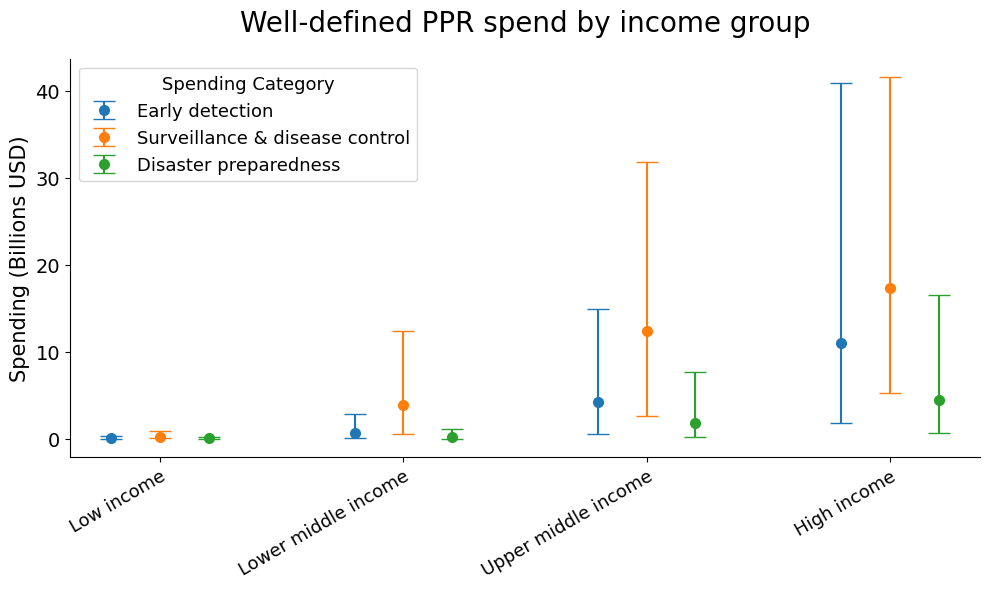

In [161]:
# Define PPR-relevant HC codes
ppr_hc_codes = ['6.3', '6.5', '6.6']

# Filter dataset
ppr_data = ds_income_group[ds_income_group['hc'].isin(ppr_hc_codes)]
df_ppr = ppr_data.reset_index()

# Define order
income_groups = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
categories = df_ppr['hc_name_clean'].unique()

# Bar settings
x = np.arange(len(income_groups))
width = 0.2

# Plot
plt.figure(figsize=(10, 6))

for i, cat in enumerate(categories):
    cat_df = df_ppr[df_ppr['hc_name_clean'] == cat].set_index('income_group').reindex(income_groups)
    plt.errorbar(
        x + i*width,
        cat_df['value'],
        yerr=[cat_df['value'] - cat_df['lower'], cat_df['upper'] - cat_df['value']],
        fmt='o',
        label=cat,
        capsize=8,
        markersize=7
    )

plt.xticks(
    x + width * (len(categories) - 1) / 2,
    income_groups,
    rotation=30,
    rotation_mode='anchor',
    ha='right',
    fontsize=tick_fontsize
)
plt.ylabel("Spending (Billions USD)", fontsize=label_fontsize)
plt.title("Well-defined PPR spend by income group", fontsize=title_fontsize, pad=20)
plt.legend(title="Spending Category", fontsize=legend_fontsize, title_fontsize=legend_fontsize)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.yticks(fontsize=ytick_fontsize)
plt.tight_layout()
plt.show()

In [182]:
ppr_categories = df_ppr['hc_name_clean'].unique()

# Initialize table (transpose: income_groups as index, categories as columns)
ppr_summary_table = pd.DataFrame(index=income_groups, columns=list(ppr_categories) + ['Total'])

# Populate the table with formatted strings (convert from billions to millions)
for group in income_groups:
    group_totals = {'value': 0, 'lower': 0, 'upper': 0}
    for category in ppr_categories:
        row = df_ppr[(df_ppr['hc_name_clean'] == category) & (df_ppr['income_group'] == group)]
        if not row.empty:
            val = row['value'].values[0] * 1000  # Convert billions to millions
            lower = row['lower'].values[0] * 1000
            upper = row['upper'].values[0] * 1000
            formatted = f"{val:,.0f} ({lower:,.0f} – {upper:,.0f})"
            ppr_summary_table.loc[group, category] = formatted
            # Add to totals
            group_totals['value'] += val
            group_totals['lower'] += lower
            group_totals['upper'] += upper
        else:
            ppr_summary_table.loc[group, category] = "—"
    # Add total column for this income group
    if group_totals['value'] > 0:
        formatted_total = f"{group_totals['value']:,.0f} ({group_totals['lower']:,.0f} – {group_totals['upper']:,.0f})"
        ppr_summary_table.loc[group, 'Total'] = formatted_total
    else:
        ppr_summary_table.loc[group, 'Total'] = "—"

# Optionally, give it a nice title
ppr_summary_table.index.name = "Income Group"

ppr_summary_table.to_csv("../data/clean/ppr_spend_table_millions.csv")

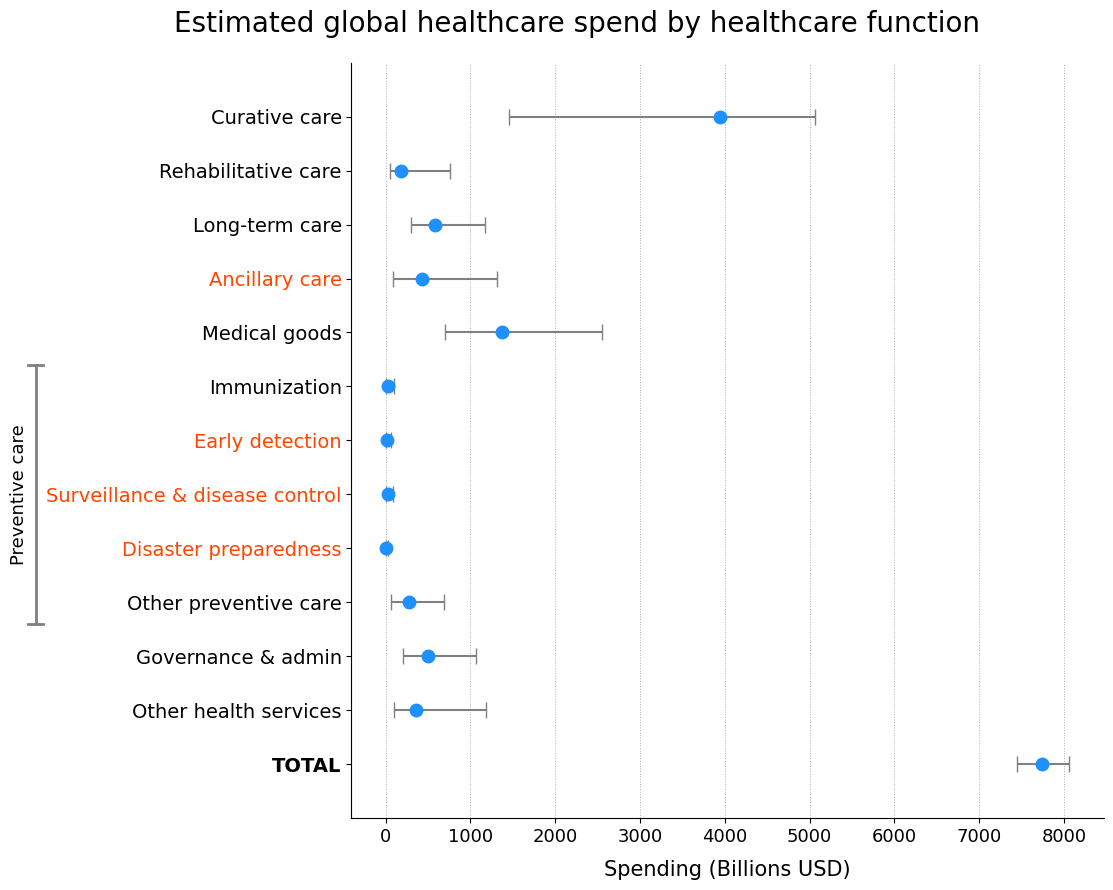

In [171]:
# 1. Aggregate totals across income groups
agg = ds_income_group.groupby(['hc', 'hc_name_clean'])[['lower', 'value', 'upper']].sum().reset_index()

# Filter subcategories
preventive_sub = agg[agg['hc'].astype(str).str.startswith('6.')]
non_preventive = agg[~agg['hc'].astype(str).str.startswith('6.')]
plot_df = pd.concat([non_preventive, preventive_sub], ignore_index=True)
plot_df = plot_df[plot_df['hc_name_clean'] != 'Preventative care']

# Sort ascending by HC code (so plots are ordered top-down)
plot_df['hc_sort'] = plot_df['hc'].astype(str).str.extract(r'(\d+(?:\.\d+)?)').astype(float)
is_total = plot_df['hc_name_clean'].str.lower().str.contains('total')
plot_df = pd.concat([plot_df[~is_total].sort_values('hc_sort', ascending=True), plot_df[is_total]], ignore_index=True)

# Identify pandemic-preparedness-relevant items
ppr_keywords = ['Ancillary care', 'Early detection', 'Surveillance & disease control', 'Disaster preparedness']
plot_df['is_ppr'] = plot_df['hc_name_clean'].isin(ppr_keywords)

# Y positions and labels
plot_df = plot_df.reset_index(drop=True)
y_pos = list(range(len(plot_df)))[::-1]  # reversed for top-down
plot_df['y'] = y_pos

# Start plot
fig, ax = plt.subplots(figsize=(12, 9))

# Plot error bars
ax.errorbar(
    plot_df['value'],
    plot_df['y'],
    xerr=[plot_df['value'] - plot_df['lower'], plot_df['upper'] - plot_df['value']],
    fmt='o',
    color='dodgerblue',
    ecolor='gray',
    capsize=6,
    markersize=9
)

# Set y-axis labels, coloring the PPR labels
ytick_labels = []
ytick_colors = []
for _, row in plot_df.iterrows():
    color = 'orangered' if row['is_ppr'] else 'black'
    label = row['hc_name_clean'].upper() if 'total' in row['hc_name_clean'].lower() else row['hc_name_clean']
    ytick_labels.append(label)
    ytick_colors.append(color)

# Set ticks
ax.set_yticks(plot_df['y'])
yticklabels_objs = ax.set_yticklabels(ytick_labels, fontsize=ytick_fontsize)
for ticklabel, color in zip(yticklabels_objs, ytick_colors):
    ticklabel.set_color(color)
    if ticklabel.get_text().upper() == "TOTAL":
        ticklabel.set_fontweight("bold")
        ticklabel.set_fontsize(ytick_fontsize + 2)

# Add brace/line to indicate Preventive Care subcategories
preventive_indices = plot_df[plot_df['hc'].astype(str).str.startswith('6.')].index
if not preventive_indices.empty:
    y0 = plot_df.loc[preventive_indices.max(), 'y'] - 0.4
    y1 = plot_df.loc[preventive_indices.min(), 'y'] + 0.4

    # Expand left margin further to make more space for the brace and label
    # plt.subplots_adjust(left=0.40)  # increased from 0.32 for more space

    # Get axis position in display coordinates
    trans = ax.get_yaxis_transform()
    # Move the brace and label further left of the ytick labels
    brace_x = -0.42  # moved further left (was -0.13)

    # Draw the vertical line (brace)
    ax.plot([brace_x, brace_x], [y0, y1], color='gray', lw=2, transform=trans, clip_on=False, zorder=10)
    # Draw the little horizontal lines at top and bottom of brace
    ax.plot([brace_x-0.01, brace_x+0.01], [y0, y0], color='gray', lw=2, transform=trans, clip_on=False, zorder=10)
    ax.plot([brace_x-0.01, brace_x+0.01], [y1, y1], color='gray', lw=2, transform=trans, clip_on=False, zorder=10)
    # Add the label vertically centered, further left
    ax.text(
        brace_x - 0.01,
        (y0 + y1) / 2,
        "Preventive care",
        rotation=90,
        va='center',
        ha='right',
        fontsize=brace_fontsize,
        transform=trans,
        clip_on=False
    )

# Style
ax.set_xlabel("Spending (Billions USD)", fontsize=label_fontsize, labelpad=10)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=ytick_fontsize)

# Add the PPR color to the title
ppr_color = 'orangered'

# Center the title manually, accounting for increased left margin (subplots_adjust)
# left=0.40 means the plot area starts at 40% from the left, so center is at (1+0.40)/2 = 0.70
ax.set_title(
    "Estimated global healthcare spend by healthcare function",
    fontsize=title_fontsize,
    pad=22,
    loc='center',
    x=0.3  # manually center title given left=0.40
)

ax.grid(axis='x', linestyle=':', linewidth=0.7)
ax.set_ylim(-1, len(plot_df))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()